这个笔记主要是记录一些关于图像项目的流程和思考。

In [70]:
import cv2
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

In [3]:
plt.rc('figure', figsize = (25, 10))

## 图像预处理手段

一般来说，图像预处理手段包括：图像灰度化、图像增强、图像滤波和图像二值化。我们分别来说一下：

1. 首先一般我们会先进行图像灰度化。为什么要进行这个操作呢，其实就是说图像上的色彩信息大多数时候是不必要的并且会增加计算量，所以我们就进行灰度化处理。（这里用到的函数就是cv2.cvtCOLOR）

2. 图像增强过程和滤波过程其实可以作为一个大的步骤。图像增强，简单的理解就是增加对比度，增加锐化程度等操作。其中增加对比度的意思就是，因为我们得到了一个灰度图像，如果这个图像的灰度比较平均，或者说大部分都集中在中间的灰度值（100-150），那么我们希望能够把最多的这部分的差异给放大。所以就有这样一个公式：$g(x,y)=T(f(x,y))$，其中T表示一个灰度变换函数。这个灰度变换函数可以是线性函数也可以是非线性函数，以线性为例我们的增强方法就很简单，如下图所示即可：

![](线性灰度对比增强.png)

3. 实际上图像滤波能够做的事情会更加全能。因为它不仅可以用来增强，还能用来模糊化图像以及做到一些更加复杂的操作。这是因为不同的卷积核得到的效果会有非常巨大的差异。（这里用到的函数就是cv2.filter2D）

* 比如说我们想要起到一个简单的锐化作用的话，一个简单的卷积核就是np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])/9，那么如果我们拿来卷积就会使得与周围有一定识别的点更加明显，起到一个锐化的作用，或者说增加对比度的作用。
* 还有就是如果我们想要加强某个方向上的白色线条的特征，比如说水平方向上的线条那么一种卷积核就是np.ones((1, 21))/21，这里的长度其实可以自己定，如果想要保留竖直方向上的白色线条的特征，那么就可以用np.ones((21, 1))/21
* 如果是一般的平滑操作，那么就使用各种方法的滤波函数：高斯滤波、中值滤波等等。这种滤波方式认为可以消除噪声，突出图像细节信息方便后续操作。我其实不是很懂，因为从肉眼上看这种滤波方式得到的结果是图像变得模糊了。但是，从另一个角度去考虑，就是说认为每一个像素点的值都会带有一些随机扰动变量，但是我们认为它们是均值为0的，所以通过对一小片区域进行平均、取中位数之类的就可以将这些噪声去掉。

4. 最后的图像二值化，主要就是将图片变成黑白图片。这里主要就是用两个函数，一个函数是cv2.threshold()，另一个函数是cv2.adaptivethreshold()。前者可以使用一些不同的参数，并通过指定阈值的方法来获得一个阈值化之后的图，但是它还包括了两个flag是可以用来自动的求阈值的，一个叫做大津算法，一个是三角算法（我们用前者比较多），这种情况下它会使用最大类间方差来求一个最好的阈值；后者就是一个自适应求阈值的方法。千万不要小巧了cv2.adaptivethreshold这个算法，如果我们能够合理地调整函数中的blocksize以及C值的话，会得到非常好的效果。

## 成像

因为要进行图像拼接，所以要接触到一些图像的转换和变形。这个部分先对图像成像的基本知识做一个介绍，大致的一个流程是：

![](成像与标定.png)

### 坐标

齐次坐标与非齐次坐标：所谓的非齐次坐标具体来说就是，如果是2D情况下表示一个点就是一个二维的向量(x,y)'，在3D情况下表示一个点就是一个三维的向量(x,y,z)'；而所谓的齐次坐标具体来说就是，对一个n维坐标增加一个维度，所以2D情况下的齐次坐标是(X,Y,W)'，注意这时候的坐标已经不能表示真实情况下的坐标了，3D情况下的齐次坐标是(X,Y,Z,W)。

$$\left[
\begin{array}{1}
\frac{X}{W}\\
\frac{Y}{W}\\
1\\
\end{array}
\right]=\left[
\begin{array}{1}
x\\
y\\
1\\
\end{array}
\right]$$

齐次坐标可以理解为一个任意缩放长度的向量，它和真实的坐标差了一个**尺度因子**。上面的表示方法对于3D情况下也是一样的。在齐次坐标中，**如果W=1，那么这时候的坐标可以认为是和真实坐标相同的；如果W=0，那么认为是不合理的，这是一个消失点。**

> 之所以我们要弄出一个齐次坐标主要原因是：可以让所有的变换都用矩阵乘法来表示，从而在计算上带来便利。

接下来我们会对二维平面上的点的非齐次坐标用$\underset{\sim}{x}$表示，它对应的齐次坐标则用$\underset{\sim}{\bar{x}}$表示，也就是说这个齐次坐标的最后一个维度的值为1；对于3D点的齐次坐标我们用$\underset{\sim}{X}$表示，它对应的齐次坐标则用$\underset{\sim}{\bar{X}}$

### 2D变换

#### 仿射变换（affine transformation）

仿射变换包括但不限于以下4种：

$$平移变换：\underset{\sim}{\bar{x'}}=\left[\begin{array}{111}
1 & 0 & tx\\0 & 1 & ty\\0 & 0 & 1\\
\end{array}\right]\cdot\underset{\sim}{\bar{x}}$$
$$旋转变换：\underset{\sim}{\bar{x'}}=\left[\begin{array}{111}
cos\theta & -sin\theta & 0\\sin\theta & cos\theta & 0\\0 & 0 & 1\\
\end{array}\right]\cdot\underset{\sim}{\bar{x}},\quad R^{-1}=R^{T}$$
$$尺度变换：\underset{\sim}{\bar{x'}}=\left[\begin{array}{111}
a & 0 & 0\\0 & b & 0\\0 & 0 & 1\\
\end{array}\right]\cdot\underset{\sim}{\bar{x}}$$
$$平行拉伸：\underset{\sim}{\bar{x'}}=\left[\begin{array}{111}
1 & shx & 0\\shy & 1 & 0\\0 & 0 & 1\\
\end{array}\right]\cdot\underset{\sim}{\bar{x}}$$

> 如果我们使用非齐次的坐标表示方法，显然我们会得到$2\times2$的矩阵变换形式，但是我们就没有办法表示平移变换。  
> 仿射变换类型都具有：**保线性、平行性、闭合性**，这些性质表现在矩阵上就是矩阵的第三行必定是0,0,1的形式。多个仿射变换矩阵相乘得到的结果仍然是仿射变换，因此也始终享受仿射变换的性质，这就是闭合性。  
> 仿射变换矩阵的自由度参数从2个到最多6个。

#### 投影变换（projective transformation）

投影变换相较于仿射变换，最主要的改变就是其不再具有平行线，只具有**保线性、闭合性**。

$$\underset{\sim}{\bar{x'}}=s\cdot\left[\begin{array}{111}
a_{11} & a_{12} & a_{13}\\a_{21} & a_{22} & a_{23}\\a_{31} & a_{32} & a_{33}\\
\end{array}\right]\cdot\underset{\sim}{\bar{x}}$$

投影变换实际上只有8个自由变动的参数，这里的原因**尚待仔细的说明**，简单来说因为要保证等式的左边还原回第三个维度是1的形式，可能要做一些限制。

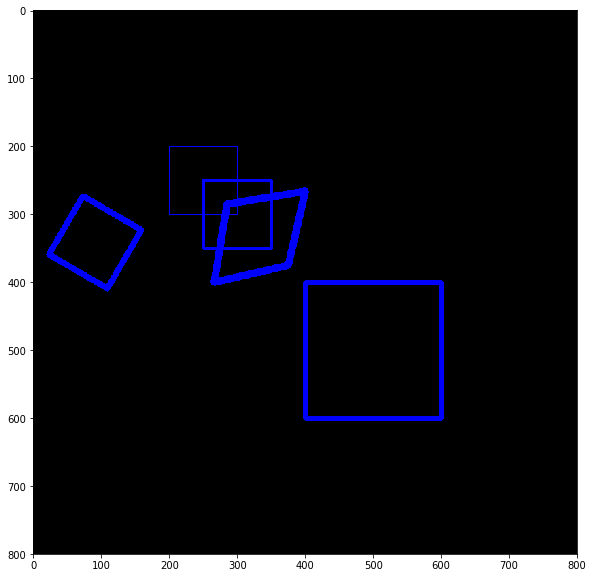

In [68]:
# 在opencv中可以使用perspectivetransform来获得经过投影变换之后的坐标，使用transform来获得经过仿射变换之后的坐标
# 如果要直接对整张图片进行旋转的话，使用warpAffine或者warpPerspective两个函数，它们分别对应两种变换
black = np.zeros((800, 800, 3))
points = np.array([[[200, 200]], [[200, 300]], [[300, 300]], [[300, 200]]], dtype = np.float32)
points1 = cv2.perspectiveTransform(points, np.array([[1, 0, 50], [0, 1, 50], [0, 0, 1]]))  # 平移变换
points2 = cv2.perspectiveTransform(points, np.array([[2, 0, 0], [0, 2, 0], [0, 0, 1]]))  # 尺度变换
points3 = cv2.perspectiveTransform(points, np.array([[np.sqrt(3) / 2, -1 / 2, 0], [1 / 2, np.sqrt(3) / 2, 0], [0, 0, 1]]))  # 旋转变换
points4 = cv2.perspectiveTransform(points, np.array([[2, 0, 0], [0, 2, 0], [0.001, 0.001, 1]]))  # 投影变换
green = (0, 255, 0)
red = (0, 0, 255)
blue = (255, 0, 0)
white = (0, 0, 0)

for i in range(0, points.shape[0] - 1):
    cv2.line(black, tuple(points[i, 0, :]), tuple(points[i + 1, 0, :]), 1, 1)
    if i + 1 == points.shape[0] - 1:
            cv2.line(black, tuple(points[i + 1, 0, :]), tuple(points[0, 0, :]), 1, 1)
for i in range(0, points1.shape[0] - 1):
    cv2.line(black, tuple(points1[i, 0, :]), tuple(points1[i + 1, 0, :]), 1, 3)
    if i + 1 == points1.shape[0] - 1:
            cv2.line(black, tuple(points1[i + 1, 0, :]), tuple(points1[0, 0, :]), 1, 3)
for i in range(0, points2.shape[0] - 1):
    cv2.line(black, tuple(points2[i, 0, :]), tuple(points2[i + 1, 0, :]), 1, 5)
    if i + 1 == points2.shape[0] - 1:
            cv2.line(black, tuple(points2[i + 1, 0, :]), tuple(points2[0, 0, :]), 1, 5)
for i in range(0, points3.shape[0] - 1):
    cv2.line(black, tuple(points3[i, 0, :]), tuple(points3[i + 1, 0, :]), 1, 7)
    if i + 1 == points3.shape[0] - 1:
            cv2.line(black, tuple(points3[i + 1, 0, :]), tuple(points3[0, 0, :]), 1, 7)
for i in range(0, points4.shape[0] - 1):
    cv2.line(black, tuple(points4[i, 0, :]), tuple(points4[i + 1, 0, :]), 1, 9)
    if i + 1 == points4.shape[0] - 1:
            cv2.line(black, tuple(points4[i + 1, 0, :]), tuple(points4[0, 0, :]), 1, 9)
plt.imshow(black[:, :, ::-1])
plt.show()

In [69]:
points4[0, 0, :]  # 可以自己算一下试试

array([285.7143, 285.7143], dtype=float32)

### 3D变换

3D变换也是类似的情况，只不过变换矩阵变成了$4\times4$了。affine transformation变换矩阵的自由参数最多有12个，perspective transformation变换矩阵的自有参数最多有16个。

唯一需要说明的是3D下的旋转可能会比较麻烦，就是说我们需要进行下列这样的计算：

$$R=R_x(\psi) * R_y(\theta) * R_z(\phi)$$

但是还有另外一种表示方式，这种表示方式会更容易计算，它可以用罗德里格斯变换完成，**这个部分尚待详细的介绍**。

> 使用欧拉角的方式，比较好理解但是存在一些问题：任何微小的旋转都可能带来三个角度巨大的变化，也就是说这个变化并不连续；各个轴的相乘顺序不确定。使用轴/角的方式就比较好计算，但是不好理解。

### 针孔相机下的3D和2D转换

我们在针孔模型下去讨论将3D物体投影到2D平面上。下面两个模型都是针孔模型，只是说前者是经典的针孔模型，而后者则是为了将计算符号稍微换一下来简化模型同时并没有改变模型的本质。为了更加清晰地讨论这个问题，我会在针孔平面和图像平面之间加入一个**感光元件平面**，并从两个层面去说明这个部分。

![](针孔摄像机模型.png)

如果我们直接使用上面的模型，那么我们就有：

$$\underset{\sim}{\bar{x}}=s\left[
\begin{array}{1111}
f_x & 0 & c_x & 0\\
0 & f_y & c_y & 0\\
0 & 0 & 1 & 0\\
\end{array}
\right]\cdot\underset{\sim}{\bar{X}}$$

实际上我们可以使用一个$2\times3$的矩阵乘上一个非齐次三维坐标就可以得到非齐次二维坐标，但是为了之后我们要一般化的表达更多的东西，我们需要将它写得复杂一点。式子中的$s=\frac{1}{Z}$是为了让左式能够形成一个第三维是1的齐次2D点坐标。

> 1.f有fx和fy是因为我们认为两个方向的投影比例不同，实际上这个写法用之后的模型解释更容易理解。  
> 2.cx和cy的出现是为了应对，当投影中心并不是图像平面时可能出现的平移。

一种更好的解释方法是将图像平面理解为**感光元件平面**，并且对这个过程进行简化：

$$\underset{\sim}{\bar{x}}=s\left[
\begin{array}{1111}
f & 0 & 0 & 0\\
0 & f & 0 & 0\\
0 & 0 & 1 & 0\\
\end{array}
\right]\cdot\underset{\sim}{\bar{X}}$$

接着我们需要将感光元件平面调整到**图像像素坐标平面**：

$$\underset{\sim}{\bar{u}}=s\left[
\begin{array}{111}
\frac{1}{dx} & 0 & \frac{u_0}{2}\\
0 & -\frac{1}{dy} & \frac{v_0}{2}\\
0 & 0 & 1\\
\end{array}
\right]\cdot\underset{\sim}{\bar{x}}$$

所以我们可以将两个矩阵相乘得到和上面几乎一样的表达方式：

$$\underset{\sim}{\bar{u}}=s\cdot\left[
\begin{array}{1111}
\frac{f}{dx} & 0 & \frac{u_0}{2} & 0\\
0 & -\frac{f}{dy} & \frac{v_0}{2} & 0\\
0 & 0 & 1 & 0\\
\end{array}\right]\cdot\underset{\sim}{\bar{X}}$$

> 主要是我们看怎么把感光元件平面调整到图像像素坐标平面，其实就是一个affine transformation就好了，而偏偏上一个矩阵本质上也是一个affine transformation（只不过多了一列）。这一步之所以要做，是因为图像的原点在左上角，我们要对坐标进行一个调整。

我们将这里找到的$3\times3$矩阵设为K，称为**相机内参矩阵**

### 针孔相机缺陷以及优化

针孔相机是一种很完美的模型，但是在现实世界里面我们不可能使用针孔相机（进光量少），一般我们使用透镜，也就是带有一定弧度和厚度的镜片。但是正是因为透镜的一些原因，使得成像过程产生了畸变，我们主要考虑的是**径向畸变**和**切向畸变**。径向畸变简单来说造成的结果就是直线变成了曲线，并且越远离中心点弯曲的程度越大；切向畸变简单来说造成的结果就是平行直线不平行（需要区别于视差问题以及由于拍摄平面与相机非垂直造成的不平行，这里指的是当我们用相机垂直拍摄许多平行直线时由于内部透镜与感光元件不平行造成的）。下面图左侧是径向，右侧是切向。

![](径向切向畸变.png)

径向畸变：使用泰勒公式去展开畸变值函数，并且由于径向畸变是对称的（在图片左侧和右侧相同距离的点的畸变值是相同的），所以有

$$f(r)=a_0+a_1r+a_2r^2+a_3r^3+a_4r^4+\cdots$$
$$\because f(\triangle r)=f(-\triangle r)\Rightarrow a_1=a_3=\cdots=0$$
$$f(r)\approx a_2r^2+a_4r^4+a_6r^6$$
$$x_{corrected}=x(1+k_1r^2+k_2r^4+k_3r^6),y_{corrected}=y(1+k_1r^2+k_2r^4+k_3r^6)$$

切向畸变：

$$x_{corrected}=x+[2p_1y+p_2(r^2+2x^2)],y_{corrected}=y+[p_1(r^2+2y^2)+2p_2x]$$

总共需要5个参数进行矫正。

### 多相机对应

在计算机视觉中有一个很重要的方向是3D重建，它就会涉及到使用多个相机之间的关系以及多个相机共同对拍摄物体进行3D坐标估计的任务，在我们面对的图像拼接任务中也要面对多相机对应的问题。

这种情况下，首先我们要处理的问题是，**世界坐标系**向**相机坐标系**的转换。在之前我们都是假设3D点的坐标就是在相机坐标系系统中的，现在我们需要完成一个基本的旋转和平移（刚体变换）：

$$\underset{\sim}{\bar{X_c}}=\left[
\begin{array}{11}
R & \underset{\sim}{t}\\
\underset{\sim}{0'} & 1\\
\end{array}\right]\cdot\underset{\sim}{\bar{X_w}}$$

上面提到的R和t称为**相机外部参数**。从而我们可以进行投影过程：

$$\left[
\begin{array}{1}
x\\
y\\
1\\
d\\
\end{array}\right]=s\cdot\left[
\begin{array}{11}
K & \underset{\sim}{0}\\
\underset{\sim}{0'} & 1\\
\end{array}\right]\cdot\left[
\begin{array}{11}
R & \underset{\sim}{t}\\
\underset{\sim}{0'} & 1\\
\end{array}\right]\cdot\underset{\sim}{\bar{X_w}}=s\left[
\begin{array}{11}
KR & K\cdot\underset{\sim}{t}\\
\underset{\sim}{0'} & 1\\
\end{array}\right]\cdot\underset{\sim}{\bar{X_w}}$$

我们会倾向于使用这种形式，因为这样我们可以比较轻松地进行矩阵计算。但是这里最大的问题是**d**是一个不可观测到的取值，我们可以知道x和y却不知道d，d被我们称为**深度**。暂且不管这个，我们先看一下如果有两个摄像机的话，我们可以如何将它们联系起来呢？很容易，只要求逆转换即可。

$$\left[
\begin{array}{1}
x_0\\
y_0\\
1\\
d_0\\
\end{array}\right]=M_{10}\cdot\left[
\begin{array}{1}
x_1\\
y_1\\
1\\
d_1\\
\end{array}\right]$$

$M_{10}$是一个由R,t和K组成的，但是问题是我们没有办法观察到d，那么所有的这些参数都没有办法估计了。

我们提供了两种可能的方法去避开这个d:

1.如果我们假设**相机坐标系全部都没有相对世界坐标系的平移，只有相对世界坐标系的旋转**，那么我们可以得到：

$$\left[
\begin{array}{1}
x\\
y\\
1\\
d\\
\end{array}\right]=s\cdot\left[
\begin{array}{11}
KR & 0\\
\underset{\sim}{0'} & 1\\
\end{array}\right]\cdot\underset{\sim}{\bar{X_w}}=s\cdot\left[
\begin{array}{1}
KR\cdot(X,Y,Z)'\\
1\\
\end{array}\right]$$

所以实际上我们完全可以得到：

$$\underset{\sim}{\bar{x_0}}=s_0\cdot K_0\cdot R_0\cdot(X,Y,Z)'$$
$$\underset{\sim}{\bar{x_1}}=s_1\cdot K_1\cdot R_1\cdot(X,Y,Z)'$$
$$\therefore \underset{\sim}{\bar{x_1}}=\frac{s_1}{s_0}K_1R_1R_0^{-1}K_0^{-1}\underset{\sim}{\bar{x_0}}$$

2.我们可以使用一些平面假设，可以对P最后一行做限制，然后我们可以令d=0。从而我们可以得到下面的式子：

$$\underset{\sim}{\bar{x_1}}=H_{10}\underset{\sim}{\bar{x_0}}$$

> 这一个部分讲的内容，完全没有使用任何除了图片以外的信息，也就是说我们并没有去尝试得到关于3D点的信息。正是因为这个原因，所以我们才必须要构造$4\times4$的矩阵，因为我们必须要有一个求逆的过程。

### 相机标定与畸变矫正

知道了这些东西之后，我们其实可以对相机进行标定以及对上述畸变进行矫正了，因为这实际上是一个逆过程。所谓相机标定就是获得相机的内部参数和外部参数，而为了进行畸变校正我们需要得到之前说到的5个参数$k_1,k_2,k_3,p_1,p_2$。

为了能够简化我们的问题，我们不能使用上面的多相机对应的模型，而是要使用**棋盘格标记**方法。实际上，这是一种非常自然的想法，我们不知道3D点的信息那么我们就去**创造3D点的信息**。做法就是：我们在相机的拍摄景象中放入一个黑白间隔的棋盘格，每个格子都是正方形且边长相等的。那么我们使用针孔相机从3D向2D投影的模型：

$$\underset{\sim}{\bar{x}}=sK[R\,|\,\underset{\sim}{t}]\cdot\underset{\sim}{\bar{X}}$$

这里我们不使用上面的$4\times4$的形式，就是因为如果我们看上面这个模型就会发现实际上2D点的坐标和3D点的坐标如果我们知道的话我们根本不需要拿2D点和其他的2D点去对应。而很幸运的是，我们是可以做到的。

对于棋盘格上面的所有角点，我们可以**一致地**（可以一次性给出坐标并且它们之间的位置关系是正确的）给出它们的3D坐标，因为我们可以**任意假设**存在这样一个世界坐标系它使得对于棋盘格上的角点来说它们的Z全都是一样的（因为棋盘是一个平面；甚至Z都设为0），而X,Y来说可以简单地按照每个边长就是1来排列。一旦我们给定了坐标，实际上就给定了一个世界坐标系，那么不同的坐标给定方法都是可以的，因为不同的3D坐标的给定只会影响到上面的R和t的估计，而不会对K和畸变参数产生影响。

当令Z=0时：

$$\underset{\sim}{\bar{x}}=sK[\underset{\sim}{r_r}\underset{\sim}{r_2}\underset{\sim}{t}]\cdot\underset{\sim}{\bar{X}}=sH\underset{\sim}{\bar{X}}$$


在这里，我们还尚未将畸变效应放进去，需要估计8个参数（投影变换矩阵参数）。上面算出来的值我们还需要进行畸变才得到图中畸变之后的实际在的坐标。

$$\left[
\begin{array}{1}
x_{actual}\\
y_{actual}\\
\end{array}\right]=(1+k_1r^2+k_2r^4+k_3r^6)\cdot\left[
\begin{array}{1}
x\\
y\\
\end{array}\right]+\left[
\begin{array}{1}
2p_1xy+p_2(r^2+2x^2)\\
p_1(r^2+2y^2)+2p_2xy\\
\end{array}\right]$$

总共我们就有15个参数，但是我们现在要看一下我们有多少个观测呢？我们只需要做一个类似于最小二乘的东西就可以了。**在棋盘格上只有4个角点是有用的信息点，其他多的都不作数**，不过这4个点可以提供8个方程，足够把针对这张图的旋转参数和平移向量估计出来了。

> 具体的由H反解相机参数过程在学习opencv中有一个稍微详细的介绍，感兴趣的话可以去看。

In [80]:
import numpy as np
import cv2
import glob

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (7,6), corners,ret)
        cv2.imshow('img',img)
        cv2.waitKey(5000)

cv2.destroyAllWindows()

In [87]:
img = cv2.imread('chess_board1.jpg')
img_size = (img.shape[0], img.shape[1])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

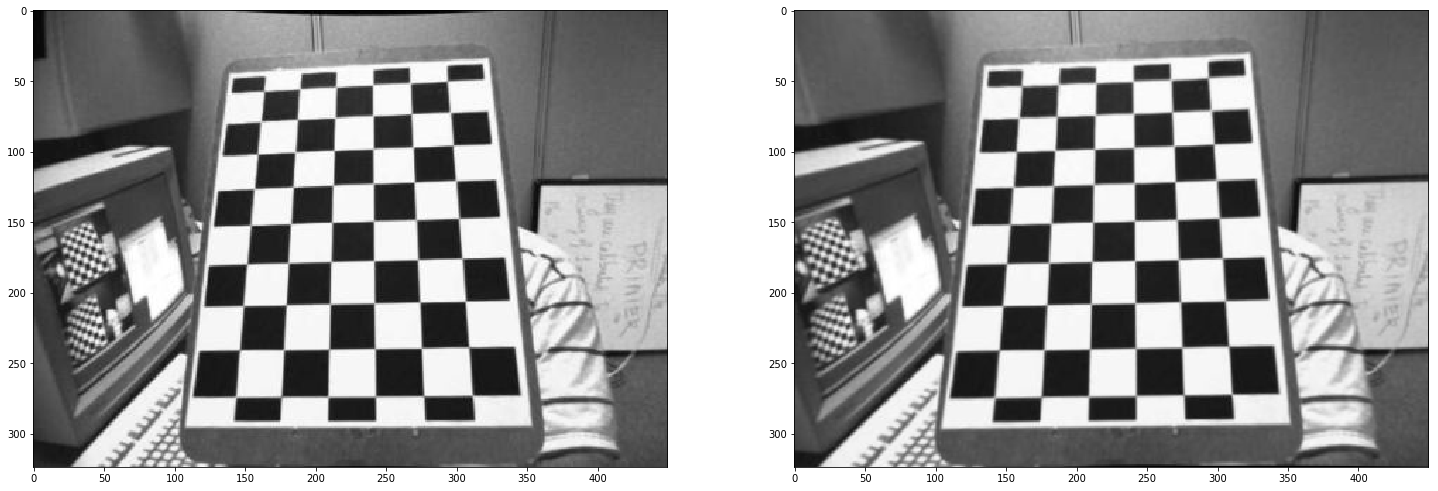

In [89]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(dst)
plt.show()

### 红外、可见图片一一对应

两张图片之间的投影变换矩阵可以使用cv2.findhomography来计算得到，只要我们能够给出对应的特征点：

1. 标记红外图片和可见光图片之间相同4组物体对应的坐标
2. 使用cv2.findhomography函数计算投影矩阵H，并记录
3. 使用cv2.warpPerspective函数，使用H获得投影结果

![](单应性结果.PNG)

> 为什么我们能够重复地去利用这样一个矩阵进行两两图片之间的投影变换呢？由上面的投影过程推导出来的结果，我给出的一种解释就是，由于我们实验的图片都是用XT2这个型号拍摄出来的，所以可见光相机和红外相机的K是固定的，同时它们之间的位置关系也是固定的，所以得到的投影矩阵也就是固定的（这里我们似乎可以忽略t的存在）

### 基于图像特征的图像拼接

下面是整个图像拼接的基本流程，我们使用的是stitcher的拼接框架。在这个框架中最重要的一个假设就是最前面提到的**相机坐标系相对于世界坐标系没有平移，只有旋转运动**，从而运动模型得到了极大的简化。

![](stitcher.png)

这整个流程中比较难的是bundle adjustment，它实际上是一个全局配准的方法，一般是用来同时估计相机姿态和3D坐标的，在这里同时对所有图片对应的所有位置统一进行配准从而比较好的估计出运动模型中的参数。在图中说到的重投影误差和射线发散误差我们可以写出它们的误差表达式：

$$E_{BA\_2D}=\sum_{i}\sum_{j}c_{ij}||\bar{x_{ij}}(x_i;R_j,f_j)-\hat{x_{ij}}||^2$$
$$E_{BA\_3D}=\sum_i\sum_jc_{ij}||\bar{x_i}(\hat{x_{ij}};R_j,f_j)-x_i||^2$$

> 前者是使用了$\underset{\sim}{\bar{x_1}}=\frac{s_1}{s_0}K_1R_1R_0^{-1}K_0^{-1}\underset{\sim}{\bar{x_0}}$这个公式，从而计算了重投影误差；而后者则是将2D点投射回3D点，计算的是射线之间的距离，也就是说它使用了$\underset{\sim}{\bar{x_0}}=s_0\cdot K_0\cdot R_0\cdot(X,Y,Z)'$这个的逆向公式。在stitcher中默认使用射线误差。

具体的求解方法，由于是非线性最小二乘方法简单来说就是使用迭代的方法，不断地寻找微小的变动量使得误差减少。

### 基于GPS的图像拼接

我们仍然想要寻找两个2D点之间的关系，但是这里我们不使用估计的方法，而是直接去计算。这里比较关键的几个点在于，**我们需要平移向量**，**我们可以通过GPS获得不同图片之间的角度变化和位移关系，那么我们不再需要构建一个虚拟的世界坐标系**。

$$K_1\cdot\left[
\begin{array}{1}
X_1\\
Y_1\\
Z_1\\
\end{array}\right]=s_1\cdot\left[
\begin{array}{1}
u_1\\
v_1\\
1\\
\end{array}\right]$$
$$R\cdot\left[
\begin{array}{1}
X_1\\
Y_1\\
Z_1\\
\end{array}\right]+\underset{\sim}{t}=\left[
\begin{array}{1}
X_2\\
Y_2\\
Z_2\\
\end{array}\right]$$
$$K_2\cdot\left[
\begin{array}{1}
X_2\\
Y_2\\
Z_2\\
\end{array}\right]=s_2\cdot\left[
\begin{array}{1}
u_2\\
v_2\\
1\\
\end{array}\right]$$
$$\Rightarrow \frac{s_1}{s_2}K_2RK_1^{-1}\cdot\left[
\begin{array}{1}
u_1\\
v_1\\
1\\
\end{array}\right]+\frac{K_2\cdot\underset{\sim}{t}}{s_2}=\left[
\begin{array}{1}
u_2\\
v_2\\
1\\
\end{array}\right]$$

这个式子如果我们没有关于t的式子，其实它就类似于上面我们得到的两张图之间的关系，但是我们现在需要有这样一个关系。由于这个原因，$s_2,s_1$的取值就变得很重要了，因为如果没有t的话其实我们是不用关注s的我们只需要对计算$KRK^{-1}$那部分，然后得到的结果进行一个齐次操作就好了，从这个意义上看实际上每一对点的s都是不同的，这对于我们的问题来说是很可怕的，因为这里我们要**直接计算K、R等参数，而不是进行估计**，这代表着s我们好像根本得不到了。

假设：

1. 摄像机成像平面和物体平面可以视为平行，从而每一个点的s在一个相机中都可以视为是相同的
2. 可以获取摄影光心到拍摄平面的高度
3. 已知相机位置信息，姿态信息，相机信息

![](GPS结果.PNG)

主要存在的问题：

1. GPS记录不准，在低高度的图上面可能造成移动方向的错误
2. 融合算法没有很好的更新
3. 假设可能要求强，如果拍摄环境进一步复杂可能无法实现